In [55]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import keras_metrics as km
# This was created with @warptime's help. Thank you!

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K
import os.path as osp
import tensorflow as tf

faces1 = pd.read_csv("../../data_files/data_from_android_api/faces/faces1.csv")
faces2 = pd.read_csv("../../data_files/data_from_android_api/faces/faces2.csv")
faces3 = pd.read_csv("../../data_files/data_from_android_api/faces/faces3.csv")
faces4 = pd.read_csv("../../data_files/data_from_android_api/faces/faces4.csv")
faces5 = pd.read_csv("../../data_files/data_from_android_api/faces/faces5.csv")

dataDF = pd.concat([faces1, faces2, faces3, faces4, faces5])

In [56]:
dataDF = dataDF.drop(dataDF[dataDF.action == 'left'].index)
dataDF = dataDF.drop(dataDF[dataDF.action == 'right'].index)

In [71]:
# create an array of shape 30706, 9 = number of records by the features
data = np.array([[0 for x in range(8)] for y in range(len(dataDF))])
for i in range(len(dataDF)):
    data[i] = [dataDF.delta.values[i],
                       dataDF.theta.values[i],
                       dataDF.alphaLow.values[i],
                       dataDF.alphaHigh.values[i],
                       dataDF.betaLow.values[i],
                       dataDF.betaHigh.values[i],
                       dataDF.gammaLow.values[i],
                       dataDF.gammaMid.values[i]]
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelEncoder()
labels = encoder.fit_transform(dataDF.action.values)

# creating training and test sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=1024)
print(x_train.max())
print(x_train.min())

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

all_labels = dataDF.action.values

all_data = dataDF.drop(['action'], axis=1)

16777204
48


/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [72]:
from keras.utils import np_utils
# convert integers to dummy variables (i.e. one hot encoded)
# creating training and test sets
x_train, x_test, y_train, y_test = train_test_split(data, labels)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [73]:
encoder.inverse_transform([np.argmax(y_test[8], axis=0)])

array(['up'], dtype=object)

In [74]:
from keras import models
from keras import layers
from keras import metrics
# from keras import regularizers kernel_regularizer=regularizers.l2(0.01), 
from keras.optimizers import Adam

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, input_shape=(8,)))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['acc', km.precision(), km.recall()])
    return model


def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model precision')
    plt.ylabel('precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("noralized confusion matrix")
    else:
        print('confusion matrix without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

Train on 722 samples, validate on 181 samples
Epoch 1/40
722/722 [==============================] - 1s 1ms/step - loss: 1.0490 - acc: 0.4266 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9959 - val_acc: 0.4144 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
722/722 [==============================] - 1s 769us/step - loss: 0.9838 - acc: 0.4737 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9918 - val_acc: 0.4862 - val_precision: 1.0000 - val_recall: 0.0149
Epoch 3/40
722/722 [==============================] - 1s 763us/step - loss: 0.9657 - acc: 0.4806 - precision: 0.5200 - recall: 0.0591 - val_loss: 1.0068 - val_acc: 0.4807 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
722/722 [==============================] - 1s 769us/step - loss: 0.9524 - acc: 0.4889 - precision: 0.2941 - recall: 0.0227 - val_loss: 0.9932 - val_acc: 0.4917 - val_precision: 1.0000 - val_recall: 0.0149
Epoch 5/40
722/722 [==============================] - 1s 766

722/722 [==============================] - 1s 851us/step - loss: 0.8012 - acc: 0.5803 - precision: 0.5294 - recall: 0.0818 - val_loss: 1.0233 - val_acc: 0.5249 - val_precision: 0.6250 - val_recall: 0.0746
Epoch 39/40
722/722 [==============================] - 1s 832us/step - loss: 0.7951 - acc: 0.6011 - precision: 0.5286 - recall: 0.1682 - val_loss: 1.0648 - val_acc: 0.4862 - val_precision: 0.3636 - val_recall: 0.0597
Epoch 40/40
302/302 [==============================] - 0s 25us/step
loss and metrics [0.9840549214786252, 0.5695364250252578, 0.6666666592592594, 0.06976744177934019]


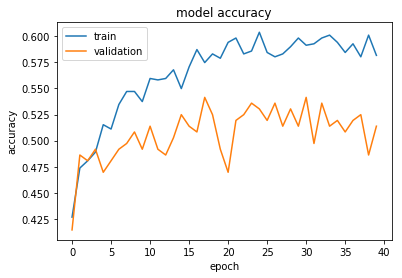

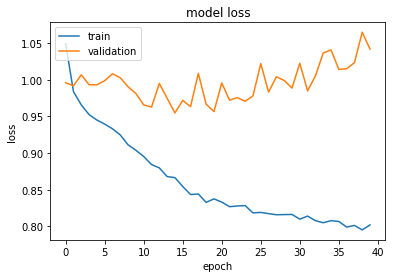

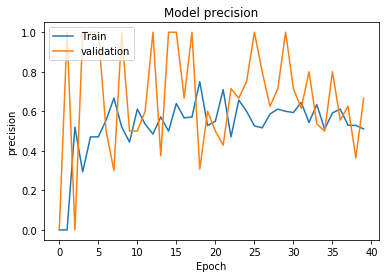

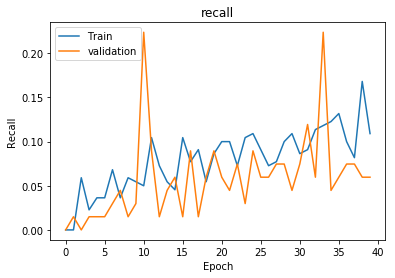

In [77]:
model = build_model()

history = model.fit(x_train, y_train,
                      validation_split=0.2,
                      epochs=40, verbose=1, batch_size=2)

loss_and_metrics = model.evaluate(x_test, y_test)
print('loss and metrics', loss_and_metrics)

plot_metrics(history)

In [78]:
y_pred = model.predict(x_test)

In [79]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [80]:
my_labels = ['down', 'rest', 'up']

confusion matrix without normalization
[[14 55 17]
 [ 8 76 24]
 [10 16 82]]


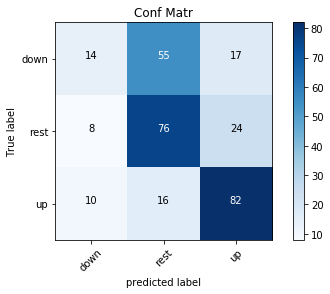

In [81]:
plot_confusion_matrix(matrix, my_labels, title='Conf Matr')

In [50]:
def keras_to_tensorflow(keras_model, output_dir, model_name,out_prefix="output_", log_tensorboard=True):

    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)

    out_nodes = []

    for i in range(len(keras_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(keras_model.output[i], out_prefix + str(i + 1))

    sess = K.get_session()

    from tensorflow.python.framework import graph_util, graph_io

    init_graph = sess.graph.as_graph_def()

    main_graph = graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)

    graph_io.write_graph(main_graph, output_dir, name=model_name, as_text=False)

    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard

        import_pb_to_tensorboard.import_to_tensorboard(
            osp.join(output_dir, model_name),
            output_dir)
        
keras_to_tensorflow(model, './out', 'faces_better.pb')

INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=./out


In [51]:
def print_graph_nodes(filename):
    import tensorflow as tf
    g = tf.GraphDef()
    g.ParseFromString(open(filename, 'rb').read())
    print()
    print(filename)
    print("=======================INPUT=========================")
    print([n for n in g.node if n.name.find('input') != -1])
    print("=======================OUTPUT========================")
    print([n for n in g.node if n.name.find('output') != -1])
    print("===================KERAS_LEARNING=====================")
    print([n for n in g.node if n.name.find('keras_learning_phase') != -1])
    print("======================================================")
    print()
    
print_graph_nodes('./out/faces_better.pb')


./out/faces_better.pb
=======================INPUT=========================
[name: "dense_36_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 8
      }
    }
  }
}
]
=======================OUTPUT========================
[name: "output_1"
op: "Identity"
input: "strided_slice"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
]
===================KERAS_LEARNING=====================
[]



In [207]:


# Binarize the output
labels = encoder.fit_transform(dataDF.action.values)
y = label_binarize(labels, classes=[0, 1, 2])
n_classes = y.shape[1]
# X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.5)
# print(y[:2])

[[0 0 1]
 [0 0 1]]


In [209]:
model2 = build_model()
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.fit(X_train, Y_train, epochs=20, batch_size=2, verbose=1)

Epoch 1/20
602/602 [==============================] - 3s 5ms/step - loss: 10.6026 - acc: 0.3422
Epoch 2/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 3/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 4/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 5/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 6/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 7/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 8/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 9/20
602/602 [==============================] - 1s 1ms/step - loss: 10.8971 - acc: 0.3239
Epoch 10/20
602/602 [==============================] - 1s 2ms/step - loss: 10.8971 - acc: 0.3239
Epoch 11/20
602/602 [==================

In [210]:
y_score = model2.predict(X_test)

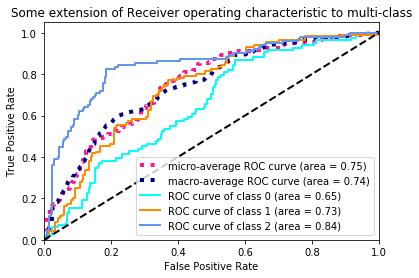

In [54]:
n_classes = 3

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()